## Data Exploration

In [5]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
s3_results_prefix = "s3://aegovan-data/processed_dataset/"
human_idmapping_dat = "/users/aeg/Downloads/HUMAN_9606_idmapping.dat"
mouse_idmapping_dat="/users/aeg/Downloads/MOUSE_10090_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [6]:
!cp $human_idmapping_dat $idmapping_dat
!cat $mouse_idmapping_dat >> $idmapping_dat
!wc -l $idmapping_dat

cat: /users/aeg/Downloads/MOUSE_10090_idmapping.dat: No such file or directory
 6050174 ./tmpmap.dat


In [7]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [8]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [9]:
download_single_file(s3_data, data_file)

In [10]:
download_single_file(s3_annotations, annotations_file)

In [11]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [12]:
data.pubmedId.nunique()

850

In [13]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [14]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [15]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
10,575312,phosphorylation,"[{'uniprotid': 'P02686-1', 'alias': [['p02686-1'], ['Myelin basic protein'], ['MBP'], ['Myelin A1 protein'], ['Myelin membrane encephalitogenic protein'], ['Golli-MBP1'], ['HOG7']], 'alternative_uniprots': []}, {'uniprotid': 'Q8I629', 'alias': [['q8i629_plaf7'], ['PF3D7_1201600']], 'alternative_uniprot

In [16]:
data.shape

(3381, 7)

In [17]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


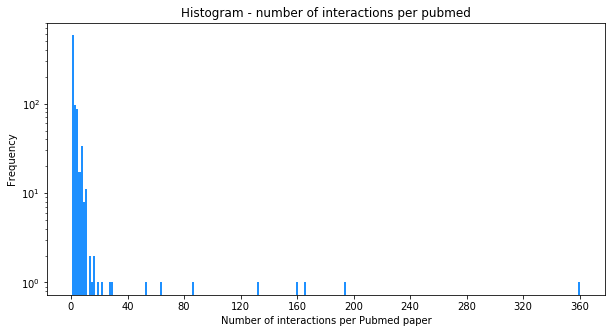

In [18]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

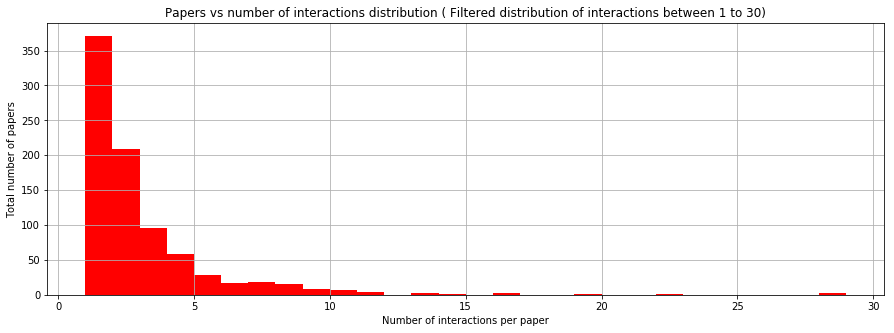

In [19]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

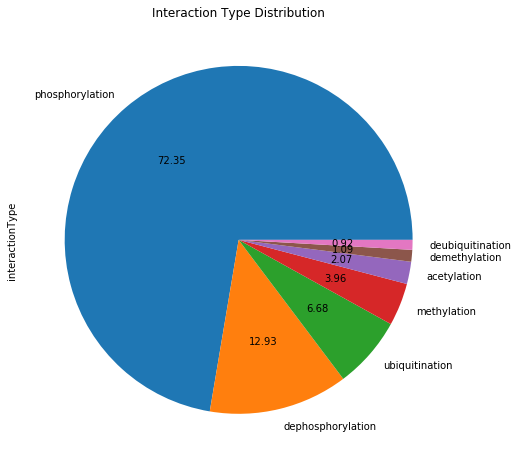

In [20]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [21]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

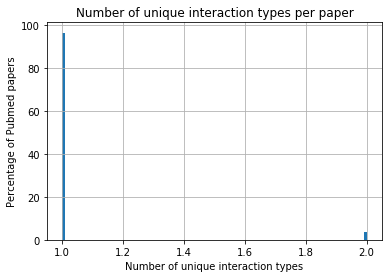

In [22]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

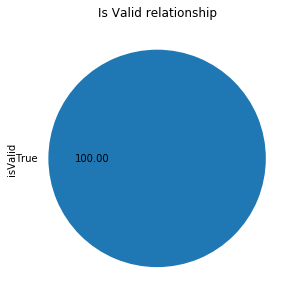

In [23]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

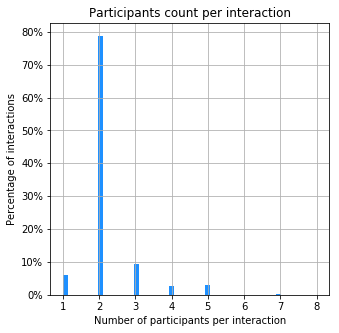

In [24]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [25]:
!pip install nltk==3.4.5

You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()
print(pd.DataFrame(data.interactionType.unique()).apply(lambda r: stemmer.stem(r.iloc[0].lower()), axis=1))

data["hasTriggerWord"] = data.apply(lambda r: stemmer.stem(r["interactionType"].lower()) in r["pubmedabstract"].lower() , 1)

0      phosphoryl
1     deubiquitin
2          methyl
3        demethyl
4          acetyl
5       ubiquitin
6    dephosphoryl
dtype: object


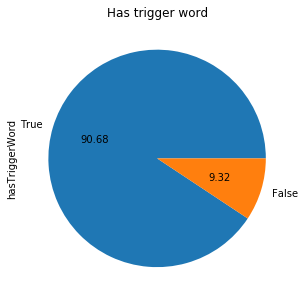

In [27]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [28]:
data.groupby([ 'interactionType','hasTriggerWord']).size().unstack().apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,7.1,92.9
demethylation,2.7,97.3
dephosphorylation,11.4,88.6
deubiquitination,22.6,77.4
methylation,0.7,99.3
phosphorylation,10.1,89.9
ubiquitination,1.8,98.2


### Explore how many of the entity alias are mentioned in the abstract

In [29]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 24.8 s, sys: 148 ms, total: 24.9 s
Wall time: 25.7 s


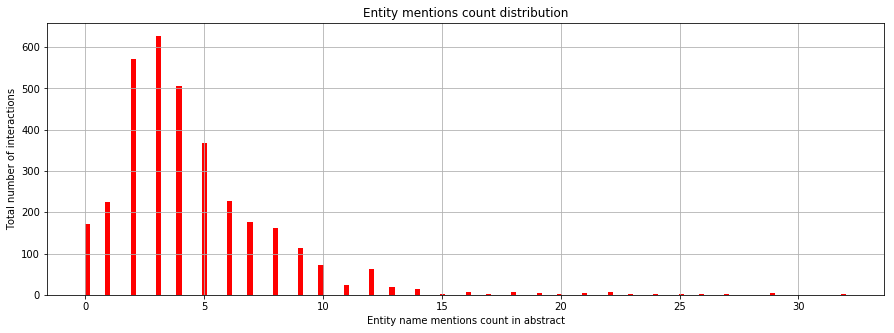

In [30]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

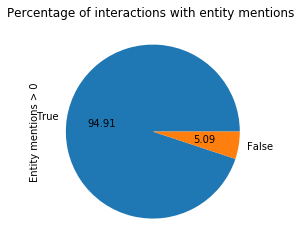

In [31]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [32]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
842,"[{'uniprotid': 'O75822', 'alias': [['eif3j_human'], ['Eukaryotic translation initiation factor 3 subunit J'], ['EIF3J'], ['PRO0391'], ['EIF3S1'], ['Eukaryotic translation initiation factor 3 subunit 1'], ['eIF-3-alpha'], ['eIF3 p35']], 'alternative_uniprots': ['Q9H8Q2', 'B4DUI3', 'F5H425', 'Q9UI65', 'Q9BUD2']}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
778,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'B4DY08', 'alias': [['b4dy08_human'], ['HNRNPC']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
751,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'Q92841-4', 'alias': [['q92841-4'], ['Probable ATP-dependent RNA helicase DDX17'], ['DEAD box protein p82'], ['DDX17'], ['DEAD box protein 17'], ['DEAD box protein p72'], ['RNA-dependent helicase p72'], ['p82']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [33]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9


## Data Transformation

### Filter interactions with more than 2 participants

In [34]:
filtered = data.query('participants_count <= 2')
filtered.shape

(2868, 10)

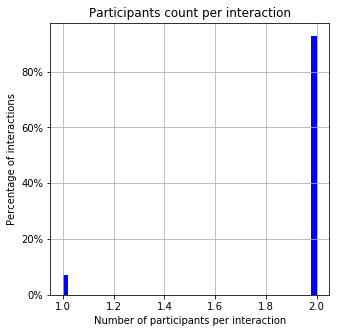

In [35]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Filter out interactions from paper with more than 15 interactions

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


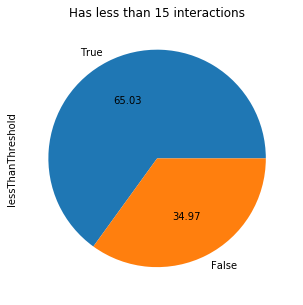

In [36]:
pubmed_interaction_count = filtered.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


#interactions_count= pd.DataFrame()
filtered["lessThanThreshold"] = filtered.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


filtered.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [37]:
filtered = filtered.query("lessThanThreshold == 1")

In [38]:
print("Total number of records after filter: {}".format(filtered.shape[0]))

Total number of records after filter: 1865


###  Flatten partcipants into participant 1 and particpiant 2

In [39]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [40]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


In [41]:
data_transformed.shape

(1865, 14)

### Remove records where the alias is null

In [42]:
data_transformed.shape

(1865, 14)

In [43]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull()]
data_filtered.shape

(1795, 14)

In [44]:
data_filtered = data_filtered[data_filtered.participant2Id.notnull()]
data_filtered.shape

(1766, 14)

In [45]:
data_filtered.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


### Normalise abstract

In [46]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        #mapper = NcbiGeneUniprotMapper()
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.textGeneNormaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [47]:
%%time
data_filtered = normalise_absract(data_filtered, annotations_file)

CPU times: user 4.4 s, sys: 169 ms, total: 4.56 s
Wall time: 5.46 s


In [48]:
data_filtered.shape

(1766, 15)

In [49]:
data_filtered.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.","O43293-2 (O43293-2) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293-2 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293-2 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to Q10728(Q10728) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293-2 to Q10728 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to Q10728, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as h

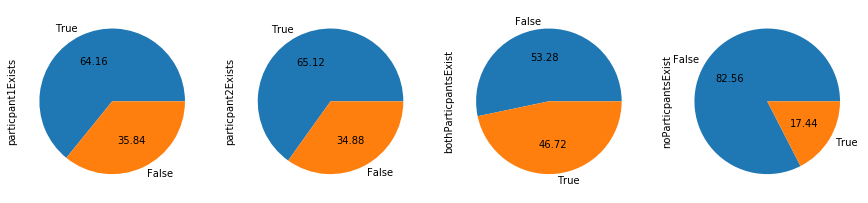

In [50]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


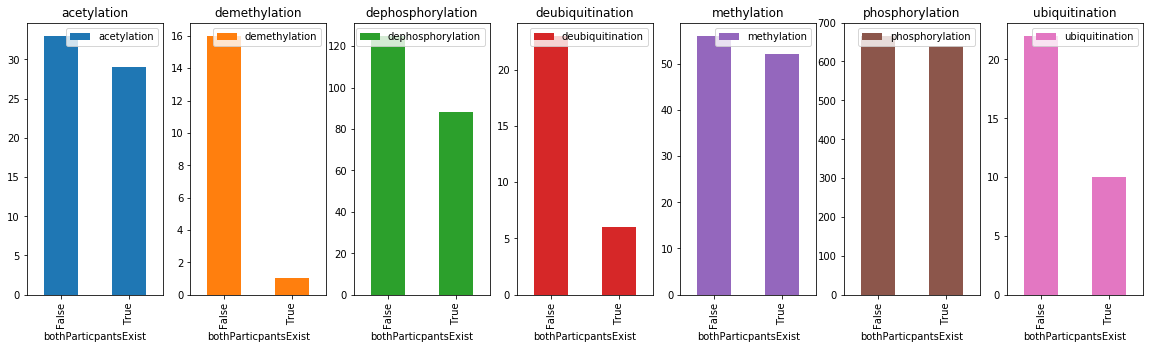

In [51]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [52]:
data_filtered.query("particpant2Exists == False").sample(4)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
395,2,True,624857,phosphorylation,True,True,"[[kpct_human], [Protein kinase C theta type], [PRKCQ], [nPKC-theta], [PRKCT]]",Q04759,"[[kpct_human], [Protein kinase C theta type], [PRKCQ], [nPKC-theta], [PRKCT]]",Q04759,1,10383400,None,"The protein kinase C (PKC) family has been clearly implicated in T-cell activation as have several nonreceptor protein-tyrosine kinases associated with the T-cell receptor, including p59fyn. This report demonstrates that thetaPKC and p59fyn specifically interact in vitro, in the yeast two-hybrid system, and in T-cells. Further indications of direct interaction are that p59fyn potentiates thetaPKC catalytic activity and that thetaPKC is a substrate for tyrosine phosphorylation by p59fyn. This interaction may account for the localization of thetaPKC following T-cell activation, pharmacological disruption of which results in specific cell-signaling defects. The demonstration of a physical interaction between a PKC and a protein-tyrosine kinase expands the class of PKC-anchoring proteins (receptors for activated C kinases (RACKs)) and demonstrates a direct connection between these two major T-cell-signaling pathways.","The protein kinase C (PKC) family has been clearly implicated in T-cell activation as have several nonreceptor protein-tyrosine kinases associated with the T-cell receptor, including P06241. This report demonstrates that thetaPKC and P06241 specifically interact in vitro, in the yeast two-hybrid system, and in T-cells. Further indications of direct interaction are that P06241 potentiates thetaPKC catalytic activity and that thetaPKC is a substrate for tyrosine phosphorylation by P06241. This interaction may account for the localization of thetaPKC following T-cell activation, pharmacological disruption of which results in specific cell-signaling defects. The demonstration of a physical interaction between a PKC and a protein-tyrosine kinase expands the class of PKC-anchoring proteins (receptors for activated C kinases (RACKs)) and demonstrates a direct connection between these two major T-cell-signaling pathways.",False,False,False,True
347,3,True,1575554,phosphorylation,True,True,"[[scn5a_human], [Sodium channel protein type 5 subunit alpha], [Sodium channel protein type V subunit alpha], [Voltage-gated sodium channel subunit alpha Nav1.5], [Sodium channel protein cardiac muscle subunit alpha], [HH1], [SCN5A]]",Q14524,"[[kcc2d_human], [Calcium/calmodulin-dependent protein kinase type II subunit delta], [CAMK2D], [CAMKD]]",Q13557,2,22514276,None,"The cardiac Na(+) channel Na(V)1.5 current (I(Na)) is critical to cardiac excitability, and altered I(Na) gating has been implicated in genetic and acquired arrhythmias. Ca(2+)/calmodulin-dependent protein kinase II (CaMKII) is up-regulated in heart failure and has been shown to cause I(Na) gating changes that mimic those induced by a point mutation in humans that is associated with combined long QT and Brugada syndromes. We sought to identify the site(s) on Na(V)1.5 that mediate(s) the CaMKII-induced alterations in I(Na) gating. We analyzed both CaMKII binding and CaMKII-dependent phosphorylation of the intracellularly accessible regions of Na(V)1.5 using a series of GST fusion constructs, immobilized peptide arrays, and soluble peptides. A stable interaction between δ(C)-CaMKII and the intracellular loop between domains 1 and 2 of Na(V)1.5 was observed. This region was also phosphorylated by δ(C)-CaMKII, specifically at the Ser-516 and Thr-594 sites. Wild-type (WT) and phosphomutant hNa(V)1.5 were co-expressed with GFP-δ(C)-CaMKII in HEK293 cells, and I(Na) was recorded. As observed in myocytes, CaMKII shifted WT I(Na) availability to a m

### Remove abstracts where both participants do not exists

In [53]:
data_filtered =  data_filtered.query('particpant2Exists == True')
data_filtered.shape

(1150, 19)

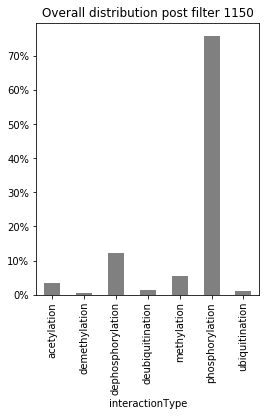

In [54]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

#### Check how many contain the trigger word

In [55]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0)

hasTriggerWord,False,True
interactionType,,
acetylation,4,36
demethylation,0,6
dephosphorylation,28,111
deubiquitination,2,13
methylation,0,64
phosphorylation,79,794
ubiquitination,0,13


In [56]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0).apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,10.0,90.0
demethylation,0.0,100.0
dephosphorylation,20.1,79.9
deubiquitination,13.3,86.7
methylation,0.0,100.0
phosphorylation,9.0,91.0
ubiquitination,0.0,100.0


### Split Train/Test/validation

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [58]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array(['23219879', '17320160', '17805299', '17567753'], dtype=object)

In [59]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15678106', '15710384', '14603323',
       '12878161', '12230472', '11588219', '11894096', '11882901',
       '19656744', '16601676', '11027293'], dtype=object)

In [60]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [61]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15710384', '12878161', '12230472',
       '11588219', '19656744', '16601676', '11027293'], dtype=object)

In [62]:
val.query("interactionType == 'ubiquitination'")


,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1181,8,True,7618,ubiquitination,True,True,"[[rnf12_human], [E3 ubiquitin-protein ligase RLIM], [RING-type E3 ubiquitin transferase RLIM], [RLIM], [RNF12], [RING finger protein 12], [LIM domain-interacting RING finger protein], [RING finger LIM domain-binding protein], [Renal carcinoma antigen NY-REN-43]]",Q9NVW2,"[[ldb1_human], [LIM domain-binding protein 1], [Nuclear LIM interactor], [Carboxyl-terminal LIM domain-binding protein 2], [LIM domain-binding factor CLIM2], [LDB1], [CLIM2]]",Q86U70,2,11882901,None,"The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with RLIM (RING finger LIM domain-binding protein) and with CLIM (cofactor of LIM-HD proteins; also known as NLI, Ldb and Chip) cofactors. The co-repressor RLIM inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify RLIM as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of RLIM with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.","The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with Q9NVW2 (Q9NVW2) and with CLIM (cofactor of LIM-HD proteins; also known as Q86U70, Ldb and Chip) cofactors. The co-repressor Q9NVW2 inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify Q9NVW2 as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of Q9NVW2 with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.",True,True,True,False


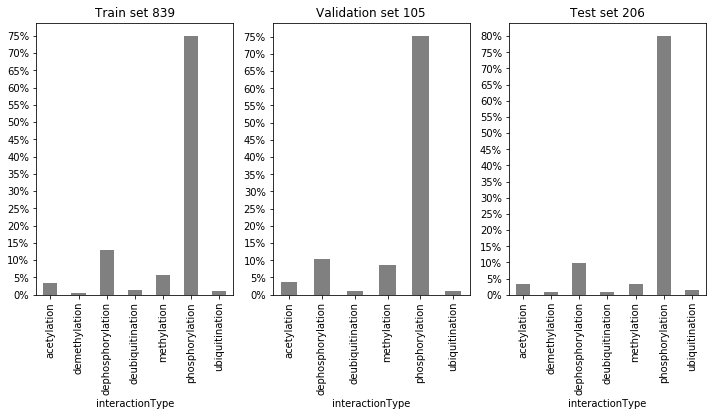

In [63]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

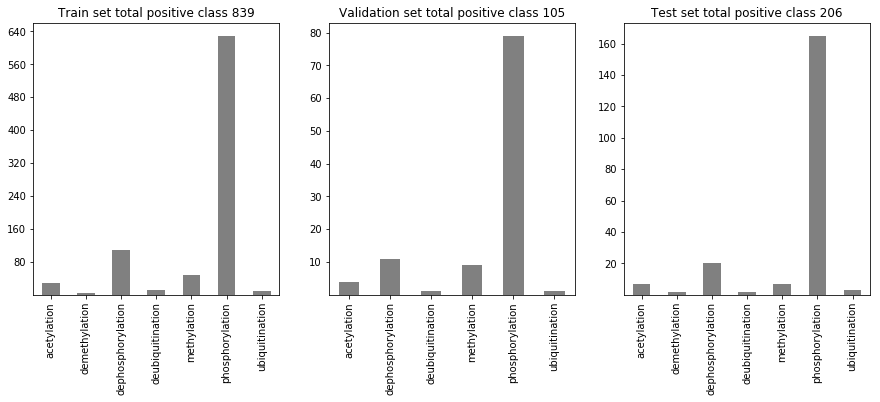

In [64]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Sample network

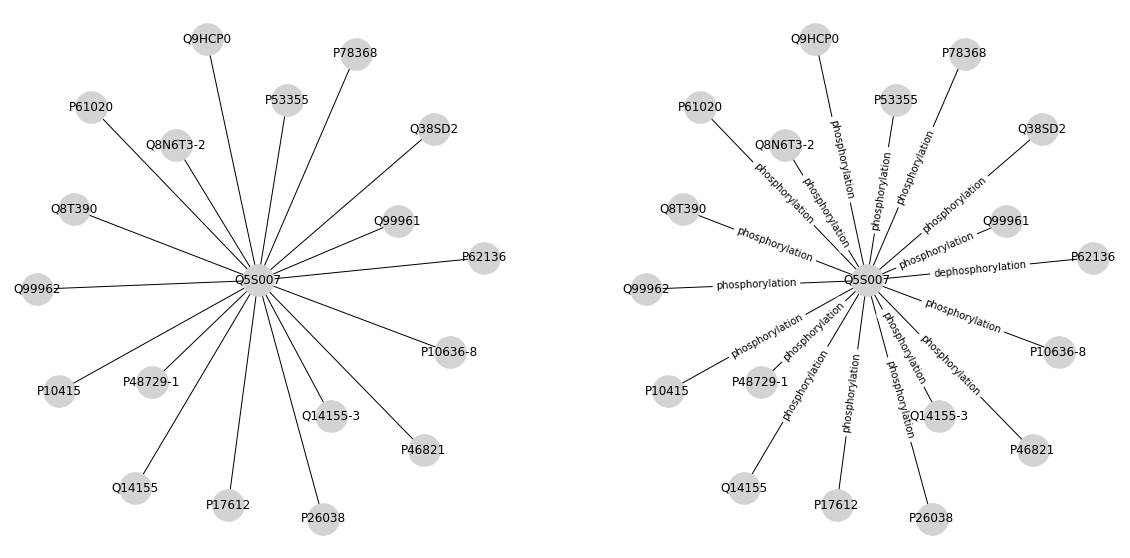

In [182]:
import networkx as nx
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,2, figsize=(20,10))

G=nx.Graph()
# Add nodes and edges
G.add_edges_from(train.query(" participant2Id =='Q5S007' and participant1Id != participant2Id")
                 .apply(lambda x: ( x["participant1Id"],x["participant2Id"], {"type": x['interactionType']}), axis=1))


pos = nx.spring_layout(G,  seed=80)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[0])



nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[1])
nx.draw_networkx_edge_labels(G, pos=pos,alpha=1,  edge_labels = nx.get_edge_attributes(G,'type'),ax=ax[1])

plt.savefig('network.png')



plt.show()

### Generate negative samples

In [123]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [124]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [125]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [126]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [127]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [128]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



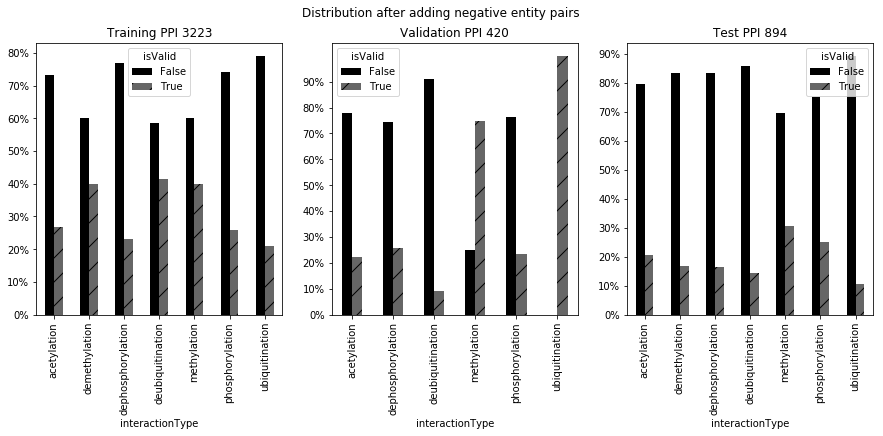

In [129]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

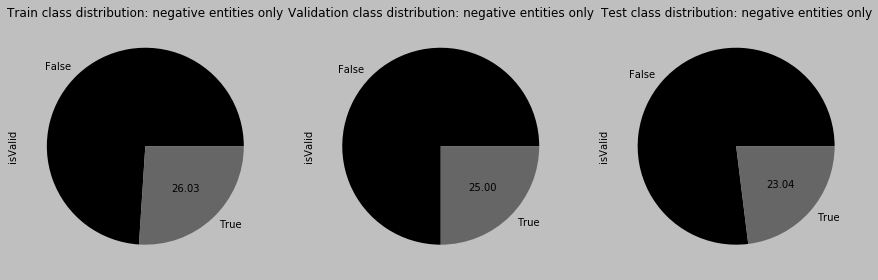

In [130]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [131]:
train_file ="train_unique_negative_entity_only.json"
train.to_json(train_file)

test_file ="test_unique_negative_entity_only.json"
test.to_json(test_file)

val_file = "val_unique_negative_entity_only.json"
val.to_json(val_file)



In [132]:
!aws s3 cp  $train_file $s3_results_prefix
!aws s3 cp  $test_file $s3_results_prefix
!aws s3 cp  $val_file $s3_results_prefix



upload: ./train_unique_negative_entity_only.json to s3://aegovan-data/processed_dataset/train_unique_negative_entity_only.json
upload: ./test_unique_negative_entity_only.json to s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json
upload: ./val_unique_negative_entity_only.json to s3://aegovan-data/processed_dataset/val_unique_negative_entity_only.json


In [133]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,79,29
demethylation,6,4
dephosphorylation,362,108
deubiquitination,17,12
methylation,72,48
phosphorylation,1814,629
ubiquitination,34,9


In [134]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,256.0,79.0
ubiquitination,NaN,1.0


In [135]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [136]:
feature_cols = ["pubmedId","pubmedabstract", "normalised_abstract", "participant1Id", "participant2Id", "interactionType", "isValid"]
derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [137]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [138]:
feature_cols = ["pubmedId","pubmedabstract", "normalised_abstract", "participant1Id", "participant2Id", "class"]


train_multiclass = train_multiclass[ feature_cols]
test_multiclass = test_multiclass[ feature_cols]
val_multiclass = val_multiclass[ feature_cols]




In [139]:
train_multiclass["class"].value_counts()

other                2384
phosphorylation       629
dephosphorylation     108
methylation            48
acetylation            29
deubiquitination       12
ubiquitination          9
demethylation           4
Name: class, dtype: int64

In [140]:
test_multiclass["class"].value_counts()

other                688
phosphorylation      165
dephosphorylation     20
methylation            7
acetylation            7
ubiquitination         3
deubiquitination       2
demethylation          2
Name: class, dtype: int64

In [141]:
val_multiclass["class"].value_counts()

other                315
phosphorylation       79
dephosphorylation     11
methylation            9
acetylation            4
deubiquitination       1
ubiquitination         1
Name: class, dtype: int64

In [142]:
train_multi_file="train_multiclass.json"
train_multiclass.to_json(train_multi_file)

test_multi_file="test_multiclass.json"
test_multiclass.to_json(test_multi_file)

val_multi_file="val_multiclass.json"
val_multiclass.to_json(val_multi_file)

In [143]:
!aws s3 cp  $val_multi_file $s3_results_prefix
!aws s3 cp  $test_multi_file $s3_results_prefix
!aws s3 cp  $train_multi_file $s3_results_prefix

upload: ./val_multiclass.json to s3://aegovan-data/processed_dataset/val_multiclass.json
upload: ./test_multiclass.json to s3://aegovan-data/processed_dataset/test_multiclass.json
upload: ./train_multiclass.json to s3://aegovan-data/processed_dataset/train_multiclass.json


In [144]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")

#### Step 2: Add negative interaction types

In [145]:

# train = generate_negative_interaction(train)
# test = generate_negative_interaction(test)
# val = generate_negative_interaction(val)


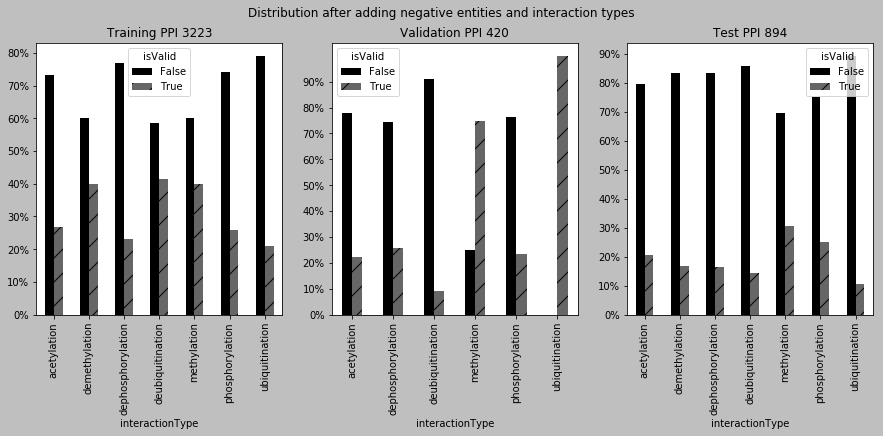

In [146]:

fig, ax = plt.subplots( 1,3, figsize=(15,5))

plot_negative_distribution(train,  val, test, "Distribution after adding negative entities and interaction types",fig, ax)
plt.savefig("EntityInteractionNegativeSample.png",bbox_inches = "tight")
plt.savefig("EntityInteractionNegativeSample.svg",bbox_inches = "tight")
plt.show()

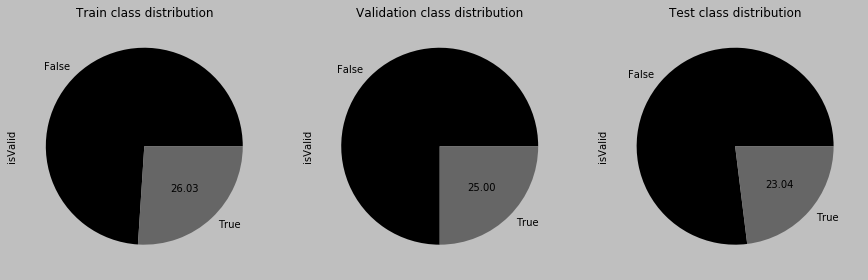

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("Interaction.png")

In [148]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,79,29
demethylation,6,4
dephosphorylation,362,108
deubiquitination,17,12
methylation,72,48
phosphorylation,1814,629
ubiquitination,34,9


In [149]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [150]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,256.0,79.0
ubiquitination,NaN,1.0


In [151]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [152]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,256.0,79.0
ubiquitination,NaN,1.0


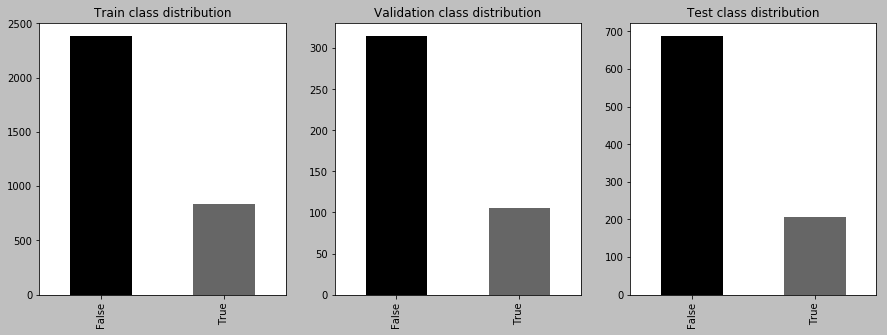

In [153]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.bar( ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.bar( ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.bar( ax=ax[2])



plt.savefig("Interaction.png")

In [154]:
train.to_json("train_unique_pub_v6_max_neg.json")
test.to_json("test_unique_pub_v6_max_neg.json")
val.to_json("val_unique_pub_v6_max_neg.json")

In [155]:
train.sample(n=20).to_json("sample_train.json")

In [156]:
train.query('isValid == True').sample(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
2735,3,True,1496038,phosphorylation,True,True,"[[moes_human], [Moesin], [Membrane-organizing extension spike protein], [MSN]]",P26038,"[[lrrk2_human], [Leucine-rich repeat serine/threonine-protein kinase 2], [LRRK2], [PARK8], [Dardarin]]",Q5S007,2,24351927,None,"Leucine-rich repeat kinase 2 (LRRK2) is a multidomain protein implicated in Parkinson disease (PD); however, the molecular mechanism and mode of action of this protein remain elusive. cAMP-dependent protein kinase (PKA), along with other kinases, has been suggested to be an upstream kinase regulating LRRK2 function. Using MS, we detected several sites phosphorylated by PKA, including phosphorylation sites within the Ras of complex proteins (ROC) GTPase domain as well as some previously described sites (S910 and S935). We systematically mapped those sites within LRRK2 and investigated their functional consequences. S1444 in the ROC domain was confirmed as a target for PKA phosphorylation using ROC single-domain constructs and through site-directed mutagenesis. Phosphorylation at S1444 is strikingly reduced in the major PD-related LRRK2 mutations R1441C/G/H, which are part of a consensus PKA recognition site ((1441)RASpS(1444)). Furthermore, our work establishes S1444 as a PKA-regulated 14-3-3 docking site. Experiments of direct binding to the three 14-3-3 isotypes gamma, theta, and zeta with phosphopeptides encompassing pS910, pS935, or pS1444 demonstrated the highest affinities to phospho-S1444. Strikingly, 14-3-3 binding to phospho-S1444 decreased LRRK2 kinase activity in vitro. Moreover, substitution of S1444 by alanine or by introducing the mutations R1441C/G/H, abrogating PKA phosphorylation and 14-3-3 binding, resulted in increased LRRK2 kinase activity. In conclusion, these data clearly demonstrate that LRRK2 kinase activity is modulated by PKA-mediated binding of 14-3-3 to S1444 and suggest that 14-3-3 interaction with LRRK2 is hampered in R1441C/G/H-mediated PD pathogenesis.","Q5S007 (Q5S007) is a multidomain protein implicated in Parkinson disease (PD); however, the molecular mechanism and mode of action of this protein remain elusive. cAMP-dependent protein kinase (PKA), along with other kinases, has been suggested to be an upstream kinase regulating Q5S007 function. Using MS, we detected several sites phosphorylated by PKA, including phosphorylation sites within the Ras of complex proteins (ROC) GTPase domain as well as some previously described sites (S910 and S935). We systematically mapped those sites within Q5S007 and investigated their functional consequences. 1076813 in the ROC domain was confirmed as a target for PKA phosphorylation using ROC single-domain constructs and through site-directed mutagenesis. Phosphorylation at 1076813 is strikingly reduced in the major PD-related Q5S007 mutations R1441C/G/H, which are part of a consensus PKA recognition site ((1441)RASpS(1444)). Furthermore, our work establishes 1076813 as a PKA-regulated 14-3-3 docking site. Experiments of direct binding to the three 14-3-3 isotypes gamma, theta, and zeta with phosphopeptides encompassing pS910, pS935, or pS1444 demonstrated the highest affinities to phospho-1076813. Strikingly, 14-3-3 binding to phospho-1076813 decreased Q5S007 kinase activity in vitro. Moreover, substitution of 1076813 by alanine or by introducing the mutations R1441C/G/H, abrogating PKA phosphorylation and 14-3-3 binding, resulted in increased Q5S007 kinase activity. In conclusion, these data clearly demonstrate that Q5S007 kinase activity is modulated by PKA-mediated binding of 14-3-3 to 1076813 and suggest that 14-3-3 interaction with Q5S007 is hampered in R1441C/G/H-mediated PD pathogenesis.",F